In [1]:
# Import libraries
import psycopg2
import getpass
import matplotlib.pyplot as plt
import numpy as np
import os.path
import time

In [2]:
# load the data
_data = np.load('res/admission.npy', allow_pickle=True).tolist()
adm_labels = _data['adm_labels']
all_adm = _data['all_adm']
first_adm = _data['first_adm']
adult_first_adm = _data['adult_first_adm']
print("Loaded!")

Loaded!


In [3]:
# Create a database connection
user = 'postgres'
host = 'localhost'
port = '5433'
dbname = 'mimic'
schema = 'mimiciii'

In [4]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path TO {}'.format(schema))
con.commit()
print("Connected!")

Password: ··········


Connected!


In [5]:
start = time.time()

# Select heart rate measurements
query = \
"""
SELECT subject_id, hadm_id, icustay_id, itemid, charttime, valuenum, valueuom
FROM chartevents
WHERE itemid = 211 OR itemid = 220045
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
heart_rate = np.array(data)

end = time.time()

# Print run time
print("This query took {} seconds".format(round((end-start),2)))

This query took 39.14 seconds


In [6]:
# Select the different units
query = \
"""
SELECT DISTINCT(valueuom)
FROM chartevents
WHERE itemid = 211 OR itemid = 220045
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
units = np.array(data)

# Display the units
print("Units:")
print(units)

Units:
[['bpm']
 ['BPM']]


In [7]:
# Check how many HR measurements are in the data set
print("No. of HR measurements: {}".format(np.shape(heart_rate)[0]))
print("No. of 'None' values: {} ({}%)".format(sum(x is None for x in heart_rate[:,5]), round(sum(x is None for x in heart_rate[:,5])/np.shape(heart_rate)[0],4)))

No. of HR measurements: 7943034
No. of 'None' values: 1446 (0.0002%)


In [8]:
print("Shape of heart_rate before removing None values: {}".format(np.shape(heart_rate)))

# Remove None values
heart_rate = heart_rate[~np.isnan(heart_rate[:,5].astype(float))]

print("Shape of heart_rate after removing None values: {}".format(np.shape(heart_rate)))

Shape of heart_rate before removing None values: (7943034, 7)
Shape of heart_rate after removing None values: (7941588, 7)


In [9]:
# Select data for hospital admission ID 145834 only
hr = heart_rate[heart_rate[:,1]==145834]

In [10]:
# Sort measurements by time
hr = hr[hr[:,4].argsort()]
hr[:,4] = hr[:,4] - adult_first_adm[:,-1][adult_first_adm[:,1]==145834] # convert raw times to time since admission
for i in range(len(hr[:,4])):
    hr[:,4][i] = hr[:,4][i].total_seconds()/(60*60)

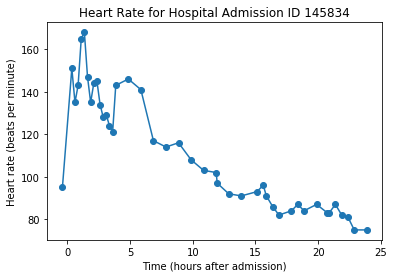

In [11]:
# Plot HR data for hospital admission ID 145834
hrs = 24 # select how many hours post admission to display
plt.plot(hr[:,4][hr[:,4]<=hrs], hr[:,5][hr[:,4]<=hrs], marker="o")
plt.xlabel('Time (hours after admission)')
plt.ylabel('Heart rate (beats per minute)')
plt.title('Heart Rate for Hospital Admission ID 145834')
plt.show()

In [12]:
print("No. of measurements in first {} hours: {}".format(hrs,len(hr[:,4][hr[:,4]<=hrs])))
print("Total no. of measurements: {}".format(len(hr[:,4])))

No. of measurements in first 24 hours: 43
Total no. of measurements: 170


In [13]:
# Get mean HR for each hour
processed_hr = np.zeros((24,2))
for i in range(24):
    hr_values = hr[:,5][np.logical_and(hr[:,4]>=i, hr[:,4]<(i+1))]
    if len(hr_values) == 0:
        hr_values = hr[:,5][np.logical_and(hr[:,4]>=(i-1), hr[:,4]<(i+2))]
    mean_hr = np.mean(hr_values)
    processed_hr[i,0] = i+1
    processed_hr[i,1] = mean_hr

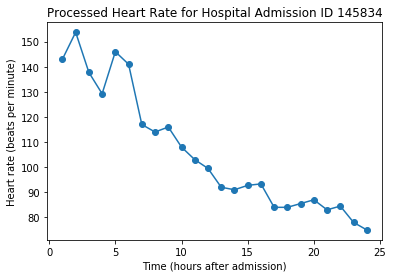

In [14]:
# Plot the processed HR data for hospital admission ID 145834
plt.plot(processed_hr[:,0], processed_hr[:,1], marker="o")
plt.xlabel('Time (hours after admission)')
plt.ylabel('Heart rate (beats per minute)')
plt.title('Processed Heart Rate for Hospital Admission ID 145834')
plt.show()

In [15]:
# Initialise a 3D numpy array for 24 hour measurements
m = len(adult_first_adm) # number of patients
hr_24h = np.zeros((m, 25, 1))

In [16]:
# Create processed 24 hour HR time series for every patient
start = time.time()

for i in range(m):
    
    # Define hospital admission ID number
    admission_id = adult_first_adm[i,1]
    
    # Select data for hospital admission ID
    hr = heart_rate[heart_rate[:,1]==admission_id]
    
    # Account for patients with no heart rate measurements
    if len(hr) == 0:
        processed_hr = np.zeros((24,1))
        
    else:
    
        # Sort measurements by time
        admit_time = adult_first_adm[i,-1]
        hr = hr[hr[:,4].argsort()]
        hr[:,4] = hr[:,4] - admit_time # convert raw times to time since admission
        for j in range(len(hr[:,4])):
            hr[:,4][j] = hr[:,4][j].total_seconds()/(60*60)
    
        # Get mean HR for each hour
        processed_hr = np.zeros((24,1))
        for k in range(24):
            hr_values = hr[:,5][np.logical_and(hr[:,4]>=k, hr[:,4]<(k+1))]
            x = 1
            while len(hr_values) == 0:
                hr_values = hr[:,5][np.logical_and(hr[:,4]>=(k-x), hr[:,4]<(k+1+x))]
                x+=1
            mean_hr = np.mean(hr_values)
            processed_hr[k] = mean_hr
    
    # Store in hr_24h
    hr_24h[i,0,:] = admission_id
    hr_24h[i,1:,:] = processed_hr
    
    # Print progress
    if (i+1) % 250 == 0:
        print("{}% complete ({}/{})".format(round((i+1)/m*100,2), i+1, m))

end = time.time()

# Evaluate run time
print("This took {} minutes".format(round((end-start)/60,2)))

0.65% complete (250/38549)
1.3% complete (500/38549)
1.95% complete (750/38549)
2.59% complete (1000/38549)
3.24% complete (1250/38549)
3.89% complete (1500/38549)
4.54% complete (1750/38549)
5.19% complete (2000/38549)
5.84% complete (2250/38549)
6.49% complete (2500/38549)
7.13% complete (2750/38549)
7.78% complete (3000/38549)
8.43% complete (3250/38549)
9.08% complete (3500/38549)
9.73% complete (3750/38549)
10.38% complete (4000/38549)
11.02% complete (4250/38549)
11.67% complete (4500/38549)
12.32% complete (4750/38549)
12.97% complete (5000/38549)
13.62% complete (5250/38549)
14.27% complete (5500/38549)
14.92% complete (5750/38549)
15.56% complete (6000/38549)
16.21% complete (6250/38549)
16.86% complete (6500/38549)
17.51% complete (6750/38549)
18.16% complete (7000/38549)
18.81% complete (7250/38549)
19.46% complete (7500/38549)
20.1% complete (7750/38549)
20.75% complete (8000/38549)
21.4% complete (8250/38549)
22.05% complete (8500/38549)
22.7% complete (8750/38549)
23.35% 

In [17]:
hr_labels = ["subject_id", "hadm_id", "icustay_id", "itemid", "charttime", "valuenum", "valueuom"]

# Save to heart_rate.npy
if not os.path.exists('./res'):
    os.makedirs('./res')

tosave = {'hr_labels': hr_labels, 'heart_rate': heart_rate, 'hr_24h': hr_24h}
np.save('res/heart_rate.npy',tosave)
print("Saved!")

Saved!
